In [130]:
#[0]
import numpy as np
from gensim.models.keyedvectors import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.test.utils import datapath, get_tmpfile
import json #https://stackoverflow.com/questions/7100125/storing-python-dictionaries
import pickle #https://stackoverflow.com/questions/11218477/how-can-i-use-pickle-to-save-a-dict
import os
#[1]
from sklearn.manifold import MDS
from scipy.spatial import procrustes
import matplotlib.pyplot as plt

%matplotlib inline

#[2]
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN

#[3]
from sklearn import decomposition
from scipy.spatial import distance_matrix


from sklearn.manifold import SpectralEmbedding
from sklearn.manifold import Isomap

from mpl_toolkits import mplot3d

In [147]:
emb = get_emotion_embedding()

In [148]:
n_dimensions = 2

# MDS

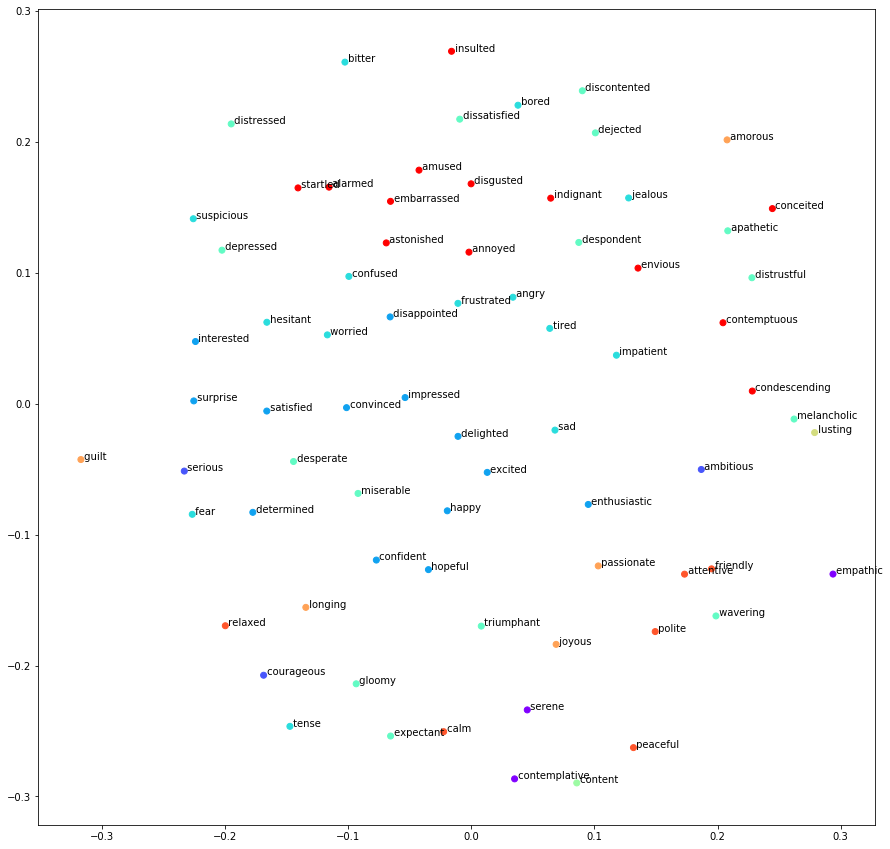

In [160]:
mds = MDS(n_components=n_dimensions,n_init=15,random_state=0)
X = mds.fit_transform(emb)
from sklearn.cluster import KMeans
clustering = KMeans(10).fit(emb)
labels = clustering.labels_
fig, ax = plt.subplots(figsize=(15,15))
ax.scatter(X[:,0], X[:,1], c=labels, cmap='rainbow')   
n = get_sentiments()
for i, txt in enumerate(n):
    ax.annotate(" "+txt, (X[:,0][i], X[:,1][i]))

# Jackplot

In [150]:
a = distance_matrix(emb,emb)
b = distance_matrix(resp,resp)

In [151]:
resp = []
for i in range(len(a)):
    for j in range(i,len(a[0])):
        if(i!=j):
            resp += [[a[i][j],b[i][j]]]

In [152]:
np.array(resp)[:,0]

array([0.29301804, 0.32968344, 0.30317925, ..., 0.3450096 , 0.34646943,
       0.30880985])

# Isomap

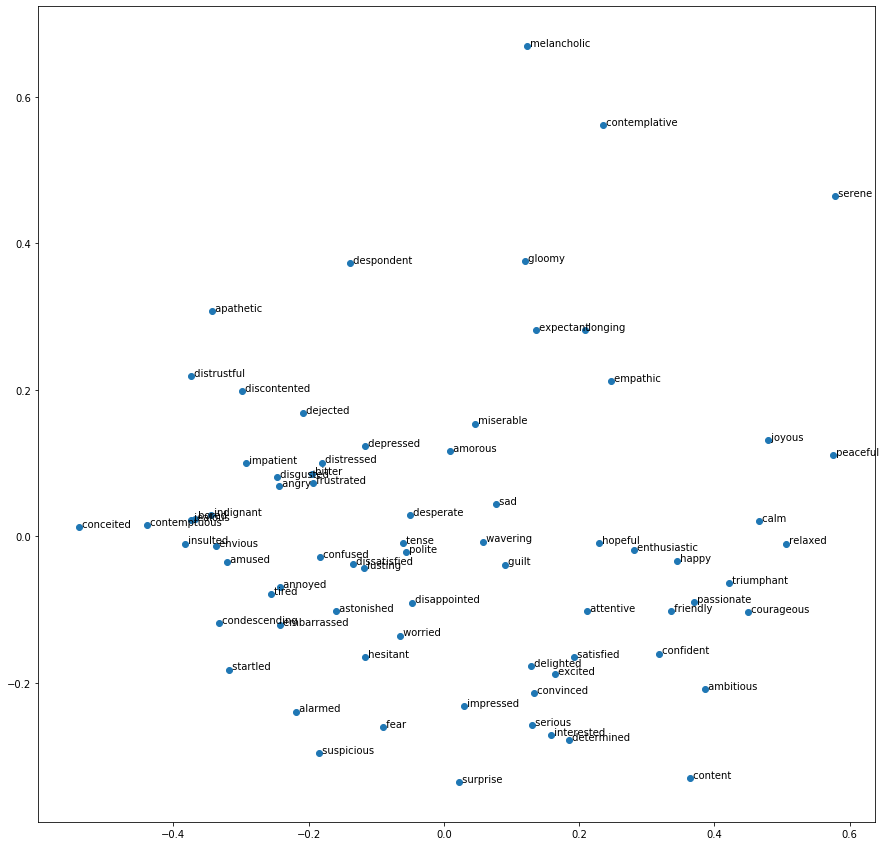

In [156]:
embedding = Isomap(n_components=2)
X_transformed = embedding.fit_transform(emb)
print_anotado(X_transformed)

# Spectral Embedding

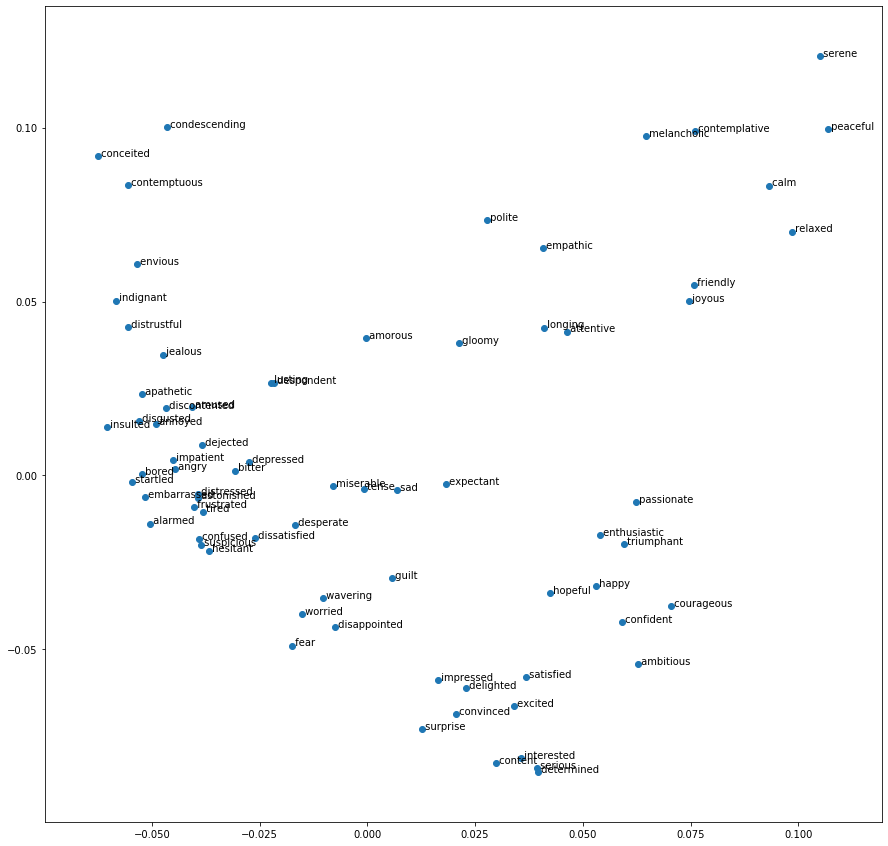

In [157]:
embedding = SpectralEmbedding(n_components=2)
X_transformed = embedding.fit_transform(emb)
print_anotado(X_transformed)

# T-SNE

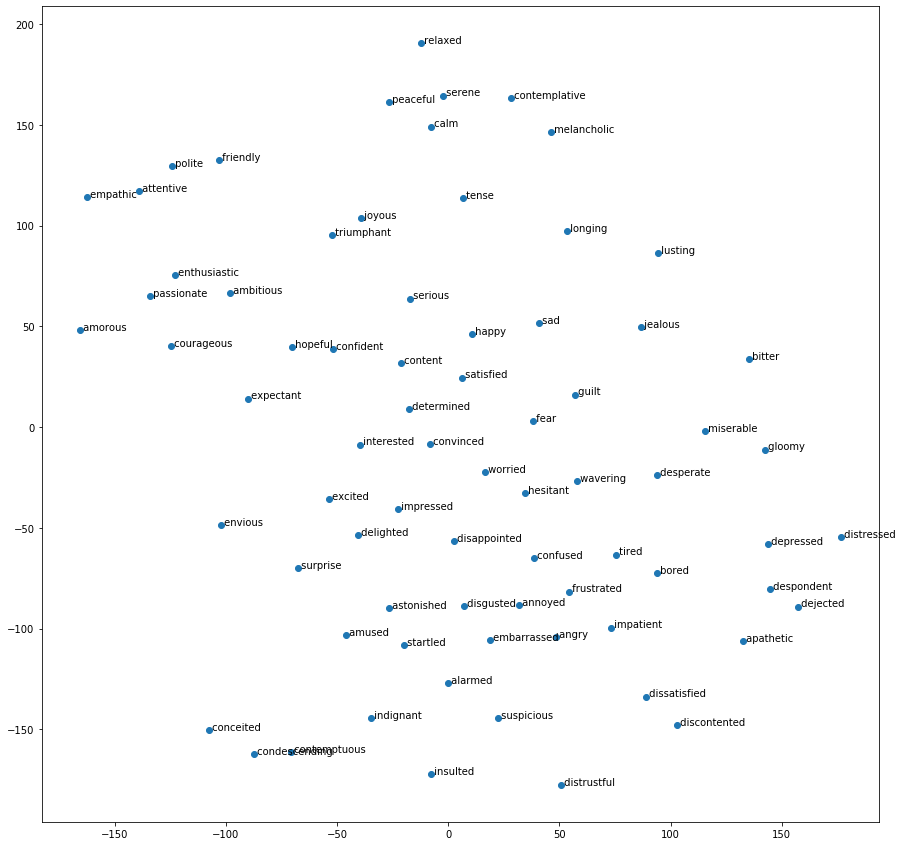

In [159]:
X_embedded = TSNE(n_components=n_dimensions,perplexity=10,random_state=0).fit_transform(emb)
print_anotado(X_embedded)

In [138]:
def get_emotion_embedding():
    return get_emb_concat()

def get_final_embs(dimensions = 200):
    embs = get_clean_embeddings()
    embs += [get_emb_soma()]
    embs += [get_emb_concat()]


    mds = MDS(n_components=dimensions)
    #Trata embeddings, filtrando somente os sentimentos principais e colocando no numero minimo de dimensoes
    embeddings = []
    for i in range(len(embs)):
        transformed_embedding = mds.fit_transform(embs[i])
        embeddings += [transformed_embedding]
    embs = embeddings

    for a in range(len(embs)):
        for b in range(len(embs)):
            embs[a],embs[b],r = procrustes(embs[a],embs[b])
    for i in range(200):
        a = np.random.randint(len(embs))
        b = np.random.randint(len(embs))
        embs[a],embs[b],r = procrustes(embs[a],embs[b])
    return embs

def calcula_stress_embeddings(d_original, d_proposta):
    d_original = distance_matrix(d_original,d_original)
    d_proposta = distance_matrix(d_proposta,d_proposta)
    a = np.sum((d_original-d_proposta)**2)
    b = np.sum(d_original**2)
    return np.sqrt(a/b)/4

def calcula_stress(d_original, d_proposta):
    a = np.sum((d_original-d_proposta)**2)
    b = np.sum(d_original**2)
    return np.sqrt(a/b)/4

def get_emb_soma():
    embeddings = get_clean_embeddings()
    sentiments = get_sentiments()
    assemble_embeddings_soma = np.zeros_like(embeddings[0])
    for i in embeddings:
        for c in range(75):
            assemble_embeddings_soma[c] = assemble_embeddings_soma[c] + i[c]
    return assemble_embeddings_soma

def get_emb_concat():
    embeddings = get_clean_embeddings()
    sentiments = get_sentiments()
    assemble_embeddings_concat = []

    for c in range(len(sentiments)):
        tmp = np.array([])
        for i in embeddings:
            tmp = np.concatenate((tmp,i[c]))
        assemble_embeddings_concat += [tmp]
    return assemble_embeddings_concat


def get_emb_media():
    #média dos vetores e retirando outliers
    embeddings = get_clean_embeddings()
    sentiments = get_sentiments()
    assemble_embeddings_media = np.zeros_like(embeddings[0])
    vec = []
    dist = []
    for c in range(75):
        tmp = np.array([])
        vec = []
        for i in embeddings:
            vec += [i[c]]

        centroid = np.zeros_like(vec[0])
        for i in vec:
            centroid = centroid + i
        centroid = centroid/len(vec)

        dist = []
        for i in vec:
            dist += [np.linalg.norm(i-centroid)]

        limitante_distancia_para_corte = np.max(dist)

        counter = 0
        for n,i in enumerate(embeddings):
            if dist[n]!=limitante_distancia_para_corte:
                assemble_embeddings_media[c] += i[c] 
                counter+=1

        assemble_embeddings_media[c] = assemble_embeddings_media[c]/counter
    return assemble_embeddings_media


def get_clean_embeddings():
#Seleciona somente os vetores principais das nossas embeddings
    sentiments = get_sentiments()
    raw_embeddings = []
    dimensions_size = []
    for i in range(4):
        tmp = get_vectors_embedding(i)
        raw_embeddings += [tmp]
        dimensions_size+=[len(get_sentiment_vector(tmp,sentiments[0]))]
#Faz o corte para o menor tamanho de dimensão
    n_dimensions = np.min(dimensions_size)
    # n_dimensions = 10
    mds = MDS(n_components=n_dimensions)
#Trata embeddings, filtrando somente os sentimentos principais e colocando no numero minimo de dimensoes
    embeddings = []
    for i in range(4):
        tmp_embedding = []
        for s in sentiments:
            tmp_embedding += [get_sentiment_vector(raw_embeddings[i],s)]
        transformed_embedding = mds.fit_transform(tmp_embedding)
        embeddings += [transformed_embedding]
    # Calcula erro entre nossos modelos
    for a in range(len(embeddings)):
        for b in range(len(embeddings)):
            embeddings[a],embeddings[b],r = procrustes(embeddings[a],embeddings[b])
    return embeddings

def print_anotado(emb):
    fig, ax = plt.subplots(figsize=(15,15))
    ax.scatter(emb[:,0], emb[:,1])
    n = get_sentiments()
    
    for i, txt in enumerate(n):
        ax.annotate(" "+txt, (emb[:,0][i], emb[:,1][i]))

def print_anotado2(emb):
    fig, ax = plt.subplots(figsize=(15,15))
    for e in emb:
        ax.scatter(e[:,0], e[:,1])
        n = get_sentiments()

        for i, txt in enumerate(n):
            ax.annotate(txt, (e[:,0][i], e[:,1][i]))

def print_2d(embs):
    res = []
    mds_2 = MDS(n_components=2)
    for e in embs:
        res += [mds_2.fit_transform(e)]
    for p in res:
        plt.scatter(p[:,0],p[:,1])

def get_sentiment_vector(embedding, sentiment):
    return embedding[sentiment]["vectors"][sentiment]

def get_vectors_embedding(n):
    files = os.listdir("models")
    model_file_name = []
    for file in files:
        model_file_name += [file]
    escolhidos = [model_file_name[14],model_file_name[5],model_file_name[7],model_file_name[3]]
    with open("models/"+escolhidos[n], 'rb') as handle:
        b = pickle.load(handle)
    return b

def get_sentiments_old():
    sentiments = np.load("./sentiments_list.npy")
    return sentiments
def get_sentiments():
    sentiments = np.load("./sentiments_list.npy")
    sentiments = np.concatenate((sentiments[:26],sentiments[27:]))
    return sentiments